In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from sklearn.preprocessing import normalize
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

### With Tf-Idf features

In [2]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [3]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [4]:
df1.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [5]:
df2.columns

Index(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [6]:
df3.columns

Index(['id', 'question1', 'question2'], dtype='object')

In [7]:
df3 = df3.fillna(' ')
df4 = pd.DataFrame()
df4['Text'] = df3.question1 + ' ' + df3.question2
df4['id'] = df3.id

In [8]:
print(df4['Text'][0])

what is the step by step guide to invest in share market in india  what is the step by step guide to invest in share market 


In [9]:
df2['id']=df1['id']
df4['id']=df1['id']
df5  = df1.merge(df2, on='id',how='left')
final  = df5.merge(df4, on='id',how='left')

In [10]:
final.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'Text'],
      dtype='object')

In [11]:
final = final.drop('id',axis=1)

In [12]:
final.shape

(404290, 27)

In [13]:
X = final[:100000]
Y = duplicate[:100000]

<h2> Random train test split( 70:30) </h2>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)  

In [15]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3),max_features=200000, min_df=5)
train_tfidf = tfidf_vect.fit_transform(X_train.Text)
test_tfidf = tfidf_vect.transform(X_test.Text)
print('No of Tfidf features: ',len(tfidf_vect.get_feature_names()))

No of Tfidf features:  67778


In [16]:
X_train = X_train.drop('Text',axis=1)
X_test = X_test.drop('Text',axis=1)

In [17]:
print(X_train.shape)

(70000, 26)


In [18]:
from scipy.sparse import hstack
X_train_tf = hstack((X_train,train_tfidf))
X_test_tf = hstack((X_test,test_tfidf))

In [19]:
X_train_tf

<70000x67804 sparse matrix of type '<class 'numpy.float64'>'
	with 3837000 stored elements in COOrdinate format>

<h1>4. Machine Learning Models </h1>

In [20]:
print("Number of data points in train data :",X_train_tf.shape)
print("Number of data points in test data :",X_test_tf.shape)

Number of data points in train data : (70000, 67804)
Number of data points in test data : (30000, 67804)


In [21]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
print("train_distr:", train_distr)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
train_distr: Counter({0: 43922, 1: 26078})
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in test data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


In [22]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8992784523713171


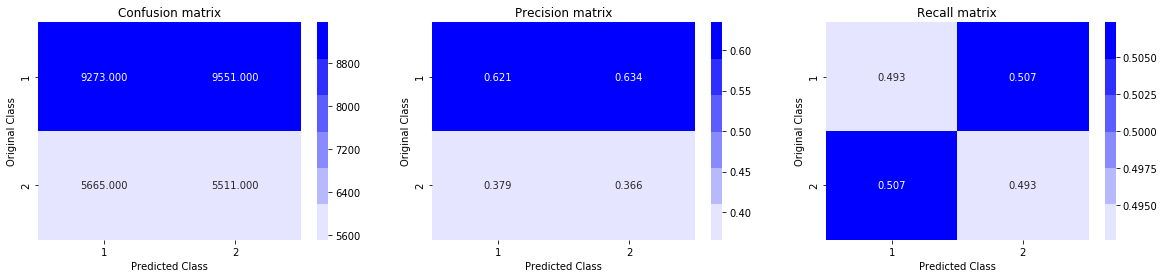

In [23]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [24]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
X_train_standardized = scale.fit_transform(X_train_tf)
X_test_standardized = scale.transform(X_test_tf)

For values of alpha =  1e-05 The log loss is: 0.48493413553237813
For values of alpha =  0.0001 The log loss is: 0.48547234194790606
For values of alpha =  0.001 The log loss is: 0.4849446312740627
For values of alpha =  0.01 The log loss is: 0.4839146208819847
For values of alpha =  0.1 The log loss is: 0.45481598477557983
For values of alpha =  1 The log loss is: 0.43307828002594156
For values of alpha =  10 The log loss is: 0.44568680023298873


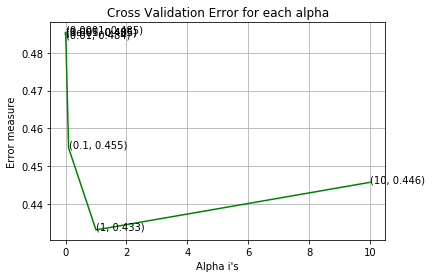

For values of best alpha =  1 The train log loss is: 0.2996696770749686
For values of best alpha =  1 The test log loss is: 0.43307828002594156
Total number of data points : 30000


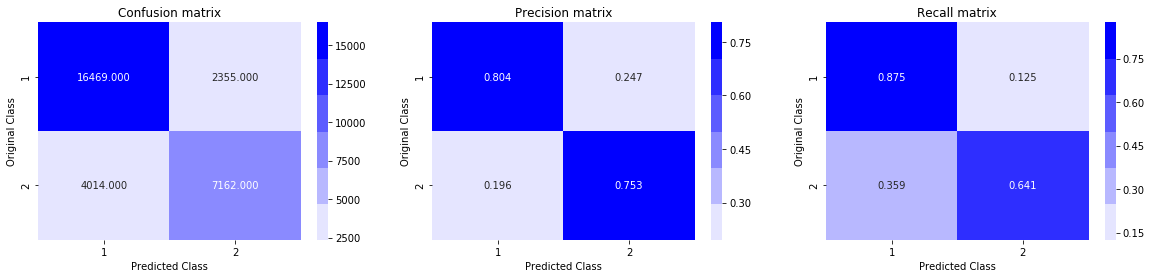

In [25]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', class_weight='balanced' , random_state=42)
    clf.fit(X_train_standardized, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_standardized, y_train)
    predict_y = sig_clf.predict_proba(X_test_standardized)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', class_weight='balanced', random_state=42)
clf.fit(X_train_standardized, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_standardized, y_train)

predict_y = sig_clf.predict_proba(X_train_standardized)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_standardized)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.49831381147210535
For values of alpha =  0.0001 The log loss is: 0.5261690005902121
For values of alpha =  0.001 The log loss is: 0.5840329479526618
For values of alpha =  0.01 The log loss is: 0.6490531407085578
For values of alpha =  0.1 The log loss is: 0.6602902109101164
For values of alpha =  1 The log loss is: 0.6602801145376358
For values of alpha =  10 The log loss is: 0.6602511748207771


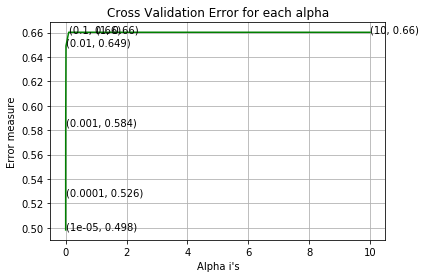

For values of best alpha =  1e-05 The train log loss is: 0.38200732210093674
For values of best alpha =  1e-05 The test log loss is: 0.49831381147210535
Total number of data points : 30000


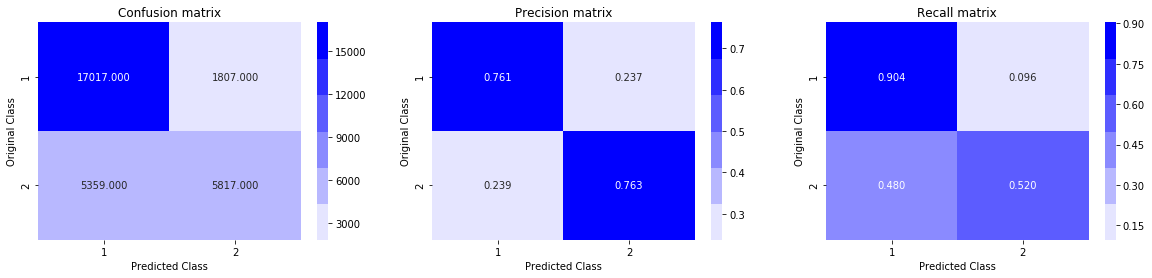

In [26]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', class_weight='balanced', random_state=42)
    clf.fit(X_train_standardized, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_standardized, y_train)
    predict_y = sig_clf.predict_proba(X_test_standardized)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', class_weight='balanced', random_state=42)
clf.fit(X_train_standardized, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_standardized, y_train)

predict_y = sig_clf.predict_proba(X_train_standardized)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_standardized)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost using TFIDF </h2>

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

### Tuning Hyperparameter for XGBoost

In [28]:
max_depth =  [1,3,5,7,9]
base_learners =  [250, 300, 350, 400, 450, 500]
learning_rate = [0.1, 0.2, 0.3, 0.4]
gamma = [1,2,3,4]
parameters = { 'max_depth' : max_depth, 'n_estimators' : base_learners, 'learning_rate' : learning_rate, 'gamma' : gamma} 

clf = XGBClassifier(random_state=0, subsample=0.7, n_jobs=-1)
randomCV = RandomizedSearchCV(clf, parameters, cv = 5, scoring='neg_log_loss', n_jobs=-1)
randomCV.fit(X_train_standardized, y_train)

print("Best Estimator: ", randomCV.best_estimator_) 
print("Best param: ", randomCV.best_params_)
print("Best Score: ", randomCV.best_score_)

best_depth = randomCV.best_params_['max_depth']
best_base_learner = randomCV.best_params_['n_estimators']
best_learning_rate = randomCV.best_params_['learning_rate']
best_gamma = randomCV.best_params_['gamma']

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=450,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)
Best param:  {'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 3}
Best Score:  -0.31265063130234794


The test log loss is: 0.3134092636212042


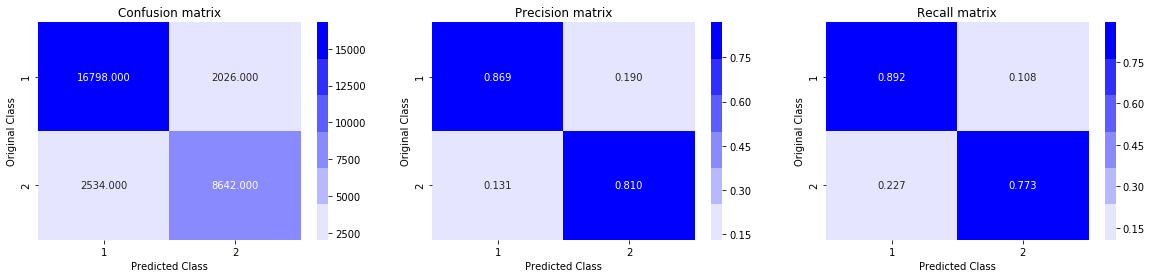

In [29]:
clf = XGBClassifier(n_estimators = best_base_learner, max_depth=best_depth, 
                    learning_rate = best_learning_rate, gamma = best_gamma,
                    random_state=0, n_jobs=-1)
clf.fit(X_train_standardized, y_train)

predict_y = clf.predict_proba(X_test_standardized)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y = clf.predict(X_test_standardized)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.7 XGBoost using TFIDF W2V </h2>

In [30]:
import spacy
import en_core_web_sm
from tqdm import tqdm

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42) 

In [32]:
# we are converting a dictionary with word as a key, and the idf as a value
word2tfidf = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [33]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [34]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for ques in tqdm(list(X_train.Text)):
    doc1 = nlp(ques) 
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_train['train_feats_m'] = list(vecs1)

100%|████████████████████████████████████| 70000/70000 [16:20<00:00, 71.38it/s]


In [35]:
vecs2 = []
for ques in tqdm(list(X_test.Text)):
    doc2 = nlp(ques) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_test['test_feats_m'] = list(vecs2)

100%|████████████████████████████████████| 30000/30000 [07:02<00:00, 71.08it/s]


In [36]:
df3_train1 = pd.DataFrame(df_train.train_feats_m.values.tolist())  
df3_test1 = pd.DataFrame(df_test.test_feats_m.values.tolist())  

In [37]:
# Train question tfidf weighted word2vec
df3_train1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,13.968866,-63.184901,-37.851235,5.811044,-28.498151,38.221898,-11.102179,-8.856164,-13.653149,51.605340,...,44.388344,-25.591820,17.777054,-12.143451,25.609721,-12.511877,-63.601957,19.403670,-54.569699,8.385999
1,57.384939,-156.107044,-155.951358,-169.042885,-29.829744,-1.305423,8.176800,16.891085,-4.929057,161.156646,...,129.467693,-81.893503,20.823759,76.624976,-74.819907,59.748898,-34.695473,25.233672,-103.738833,140.455101
2,379.818792,-298.199074,-51.950221,-410.960430,-299.308937,32.468503,510.622082,163.779142,-327.440868,187.608240,...,251.813607,-220.851223,348.802921,267.448963,88.637066,66.761008,-85.489021,73.787878,-257.661417,188.442091
3,251.250374,-212.124477,-87.309866,-195.449205,-155.368642,-45.421247,255.141276,-43.482507,-55.460201,83.770616,...,104.266868,-15.696414,249.244013,-120.002123,-110.079748,-26.659841,-78.281650,-26.431276,-83.096582,192.098389
4,80.511562,-75.859897,-83.286019,-115.316456,-103.597393,118.108827,182.983685,80.412911,-34.446471,74.906366,...,85.682100,-25.484628,49.881244,-24.895430,7.729808,-19.803591,-77.589511,-40.827592,-36.905734,62.639007


In [38]:
# Test question tfidf weighted word2vec
df3_test1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,115.053815,-68.206460,-61.690167,-237.427118,-77.485307,126.888668,116.781959,118.587657,-18.420549,177.489820,...,31.104585,-151.005301,55.904764,58.658291,-76.835143,-40.490978,-12.081293,79.679237,-35.274467,52.851797
1,-8.273353,-32.834286,-167.776374,-252.763935,-150.039904,154.125622,136.798339,22.501969,70.657251,119.849102,...,143.876671,-120.475489,57.220361,92.748662,-40.930633,94.938886,-107.737926,49.409201,-37.214383,42.510788
2,110.041769,10.358699,-41.794526,-71.787888,-27.141404,38.615737,134.692381,-2.642109,-11.916205,97.300859,...,-18.788938,63.381909,45.239259,22.850009,-31.748616,-8.182491,-24.454061,11.402220,-83.319843,5.010235
3,29.611506,-44.567275,-171.106002,-200.169049,-77.815179,79.636048,34.782515,167.700300,-7.647996,60.191667,...,40.450839,-98.483931,150.150521,-33.868922,-62.410260,29.724886,60.465015,15.658334,-20.624266,-13.190531
4,63.399042,-18.317845,-138.849730,-169.588308,-87.547020,75.461789,156.598059,154.839743,-21.179927,69.350982,...,39.623656,-35.287012,67.822415,117.560754,-2.364232,22.648313,22.964060,26.427688,-48.451892,60.621889


In [39]:
X_train = X_train.drop('Text',axis=1)
X_test = X_test.drop('Text',axis=1)

print(X_train.shape)

(70000, 26)


In [40]:
from scipy.sparse import hstack
X_train_tfw2v = hstack((X_train,df3_train1))
X_test_tfw2v = hstack((X_test,df3_test1))

In [41]:
X_train_tfw2v

<70000x122 sparse matrix of type '<class 'numpy.float64'>'
	with 8365084 stored elements in COOrdinate format>

In [42]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
X_train_tfw2v_standardized = scale.fit_transform(X_train_tfw2v)
X_test_tfw2v_standardized = scale.transform(X_test_tfw2v)

### Tuning Hyperparameter for XGBoost

In [43]:
max_depth =  [1,3,5,7,9]
base_learners =  [250, 300, 350, 400, 450, 500]
learning_rate = [0.1, 0.2, 0.3, 0.4]
gamma = [1,2,3,4]
parameters = { 'max_depth' : max_depth, 'n_estimators' : base_learners, 'learning_rate' : learning_rate, 'gamma' : gamma} 

clf = XGBClassifier(random_state=0, subsample=0.7, n_jobs=-1)
randomCV = RandomizedSearchCV(clf, parameters, cv = 5, scoring='neg_log_loss', n_jobs=-1)
randomCV.fit(X_train_tfw2v_standardized, y_train)

print("Best Estimator: ", randomCV.best_estimator_) 
print("Best param: ", randomCV.best_params_)
print("Best Score: ", randomCV.best_score_)

best_depth = randomCV.best_params_['max_depth']
best_base_learner = randomCV.best_params_['n_estimators']
best_learning_rate = randomCV.best_params_['learning_rate']
best_gamma = randomCV.best_params_['gamma']

Best Estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)
Best param:  {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 3}
Best Score:  -0.33869977963165243


The test log loss is: 0.3323952443294096


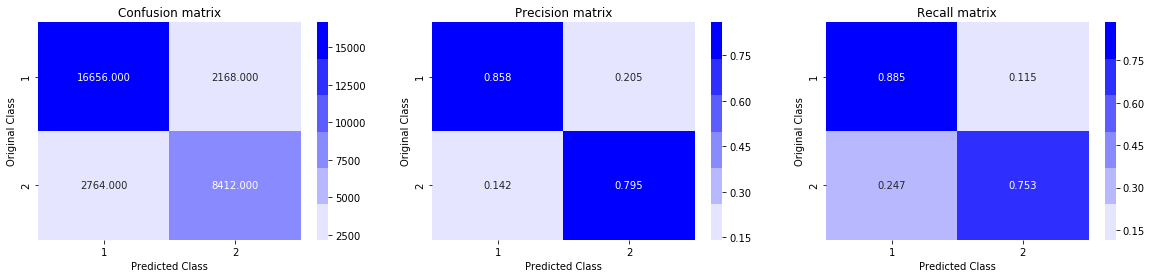

In [44]:
clf = XGBClassifier(n_estimators = best_base_learner, max_depth=best_depth, 
                    learning_rate = best_learning_rate, gamma = best_gamma,
                    random_state=0, n_jobs=-1)
clf.fit(X_train_tfw2v_standardized, y_train)

predict_y = clf.predict_proba(X_test_tfw2v_standardized)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y = clf.predict(X_test_tfw2v_standardized)
plot_confusion_matrix(y_test, predicted_y)

In [46]:
from prettytable import PrettyTable

ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",[1, 2, 3, 4, 5])
ptable.add_column("MODEL",['Random','Logistic_Regression','Linear SVM','Xgboost with TFIDF', 'XGBoost with TFIDFW2V'])
ptable.add_column("Log Loss",[0.89, 0.43, 0.49, 0.31, 0.33])

print(ptable)

+-------+-----------------------+----------+
| S.NO. |         MODEL         | Log Loss |
+-------+-----------------------+----------+
|   1   |         Random        |   0.89   |
|   2   |  Logistic_Regression  |   0.43   |
|   3   |       Linear SVM      |   0.49   |
|   4   |   Xgboost with TFIDF  |   0.31   |
|   5   | XGBoost with TFIDFW2V |   0.33   |
+-------+-----------------------+----------+


<h1> Conclusion </h1>

* Applied Tfidf Vectorization on all train questions including q1 and q2
* Applied different machine learning model e.g Logistic Regression , Linear SVM and Xgboost.
* Among all models XGBoost gave the best performace